# L1: Overview of Multimodality

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

* In this classroom, the libraries have been already installed for you.
* If you would like to run this code on your own machine, you need to install the following:
```
    !pip install -q accelerate torch
    !pip install -U scikit-learn
    !pip install umap-learn
    !pip install tqdm
```

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import libraries

In [2]:
# Import neural network training libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Import basic computation libraries along with data visualization and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
import umap
import umap.plot
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'iframe'

# Import our data class which will organize MNIST and provide anchor, positive and negative samples.
from mnist_dataset import MNISTDataset

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access Utils File and Helper Functions:</b> To access the <code>mnist_dataset.py</code> and other files for this notebook, 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>


## Load MNIST Dataset

In [3]:
# Load data from csv
data = pd.read_csv('digit-recognizer/train.csv')
val_count = 1000
# common transformation for both val and train
default_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# Split data into val and train
dataset = MNISTDataset(data.iloc[:-val_count], default_transform)
val_dataset = MNISTDataset(data.iloc[-val_count:], default_transform)

100%|██████████| 1000/1000 [00:00<00:00, 3355.25it/s]


## Setup our DataLoaders

In [9]:
labels_positive={}
labels_negative={}


for i in list(data.label.unique()):
                labels_positive[i] = data[data.label == i].to_numpy()
            # for each label create a set of image of different label.
                for i in list(data.label.unique()):
                   labels_negative[i] = data[data.label != i].to_numpy()

In [10]:
print(labels_positive)

{1: array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]]), 0: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 4: array([[4, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0]]), 7: array([[7, 0, 0, ..., 0, 0, 0],
       [7, 0, 0, ..., 0, 0, 0],
       [7, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 0, 0, ..., 0, 0, 0],
       [7, 0, 0, ..., 0, 0, 0],
       [7, 0, 0, ..., 0, 0, 0]]), 3: array([[3, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [3, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ...

In [11]:
# Create torch dataloaders
trainLoader = DataLoader(
    dataset,
    batch_size=16, # feel free to modify this value
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    prefetch_factor=100
)

valLoader = DataLoader(val_dataset,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    prefetch_factor=100
)

### Visualize datapoints

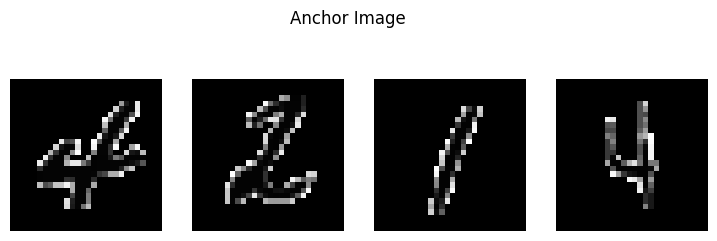

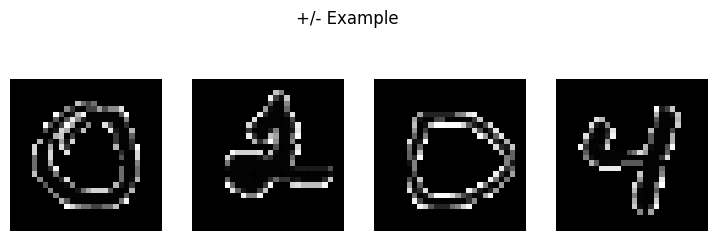

In [12]:
# Function to display images with labels
def show_images(images, title=''):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(9, 3))
    for i in range(num_images):
        img = np.squeeze(images[i])
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()

# Visualize some examples
for batch_idx, (anchor_images, contrastive_images, distances, labels) in enumerate(trainLoader):
    # Convert tensors to numpy arrays
    anchor_images = anchor_images.numpy()
    contrastive_images = contrastive_images.numpy()
    labels = labels.numpy()
    
    # Display some samples from the batch
    show_images(anchor_images[:4], title='Anchor Image')
    show_images(contrastive_images[:4], title='+/- Example')
    
    # Break after displaying one batch for demonstration
    break


> Note: Please be aware that the output from the previous cell may differ from what is shown in the video. This variation is normal and should not cause concern.

## Build Neural Network Architecture

In [13]:
# Define a neural network architecture with two convolution layers and two fully connected layers
# Input to the network is an MNIST image and Output is a 64 dimensional representation. 
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Dropout(0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Dropout(0.3)
        )
        self.linear1 = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 64),
        )

    def forward(self, x):
        x = self.conv1(x) # x: d * 32 * 12 * 12
        x = self.conv2(x) # x: d * 64 * 4  * 4 
        x = x.view(x.size(0), -1) # x: d * (64*4*4)
        x = self.linear1(x) # x: d * 64
        return x

## Contrastive Loss Function

In [14]:
# The ideal distance metric for a positive sample is set to 1, for a negative sample it is set to 0      
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.similarity = nn.CosineSimilarity(dim=-1, eps=1e-7)

    def forward(self, anchor, contrastive, distance):
        # use cosine similarity from torch to get score
        score = self.similarity(anchor, contrastive)
        # after cosine apply MSE between distance and score
        return nn.MSELoss()(score, distance) #Ensures that the calculated score is close to the ideal distance (1 or 0)

#### Define the Training Configuration

In [15]:
net = Network()

device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    
net = net.to(device)
device

'cpu'

In [16]:
# Define the training configuration
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_function = ContrastiveLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.3)

## Training Loop

In [17]:
import os

# Define a directory to save the checkpoints
checkpoint_dir = 'checkpoints/'

# Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

### Model Training

In [18]:
def train_model(epoch_count=10):#
    net = Network()
    lrs = []
    losses = []

    for epoch in range(epoch_count):
        epoch_loss = 0
        batches=0
        print('epoch -', epoch)
        lrs.append(optimizer.param_groups[0]['lr'])
        print('learning rate', lrs[-1])
    
        for anchor, contrastive, distance, label in tqdm(trainLoader):
            batches += 1
            optimizer.zero_grad()
            anchor_out = net(anchor.to(device))
            contrastive_out = net(contrastive.to(device))
            distance = distance.to(torch.float32).to(device)
            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss
            loss.backward()
            optimizer.step()

        losses.append(epoch_loss.cpu().detach().numpy() / batches)
        scheduler.step()
        print('epoch_loss', losses[-1])
    
        # Save a checkpoint of the model
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)

    return {
        "net": net,
        "losses": losses
    }

>Note: The model presented above is ready for training; however, please be aware that it may take several minutes to train. As a backup plan, we provide the option to load a pre-trained model.

### Load from Backup

In [19]:
def load_model_from_checkpoint():
    checkpoint = torch.load('checkpoints/model_epoch_99.pt')
    
    net = Network()
    net.load_state_dict(checkpoint)
    net.eval()

    return net

Set the `train` variable to `TRUE` if you'd like to train the model, otherwise you will load a trained checkpoint of the model.

### Get the Model

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> <b>(Note: <code>train = False</code>):</b> We've saved the trained model and are loading it here for speedier results, allowing you to observe the outcomes faster. Once you've done an initial run, you may set <code>train</code> to <code>True</code> to train the model yourself. This can take some time to finsih, depending the value you set for the <code>epoch_count</code>.</p>

In [20]:
train = False # set to True to run train the model

if train:
    training_result = train_model()
    model = training_result["net"]
else:
    model = load_model_from_checkpoint()

### Visualize the loss curve for your trained model

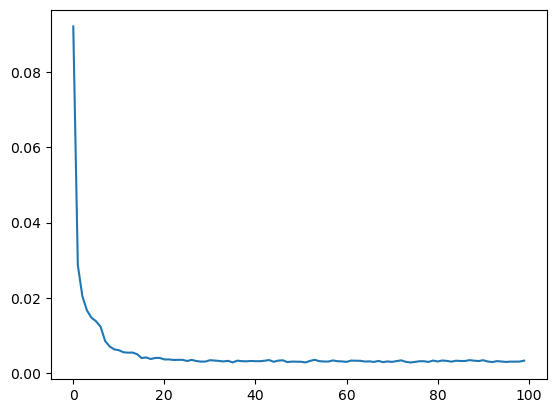

In [21]:
from IPython.display import Image

if train:
    # show loss curve from your training.
    plt.plot(training_result["losses"])
    plt.show()
else:
    # If you are loading a checkpoint instead of training the model (train = False),
    # the following line will show a pre-saved loss curve from the checkpoint data.
    display(Image(filename="images/loss-curve.png", height=600, width=600))

## Visualize the Vector Space!

### Generate 64d Representations of the Training Set

In [22]:
encoded_data = []
labels = []

with torch.no_grad():
    for anchor, _, _, label in tqdm(trainLoader):
        output = model(anchor.to(device))
        encoded_data.extend(output.cpu().numpy())
        labels.extend(label.cpu().numpy())

encoded_data = np.array(encoded_data)
labels = np.array(labels)

  0%|          | 0/2563 [00:00<?, ?it/s]

### Reduce Dimensionality of Data: 64d -> 3d

In [23]:
# Apply PCA to reduce dimensionality of data from 64d -> 3d to make it easier to visualize!
pca = PCA(n_components=3)
encoded_data_3d = pca.fit_transform(encoded_data)

### Interactive Scatter Plot in 3d – with PCA

In [24]:
scatter = go.Scatter3d(
    x=encoded_data_3d[:, 0],
    y=encoded_data_3d[:, 1],
    z=encoded_data_3d[:, 2],
    mode='markers',
    marker=dict(size=4, color=labels, colorscale='Viridis', opacity=0.8),
    text=labels, 
    hoverinfo='text',
)

# Create layout
layout = go.Layout(
    title="MNIST Dataset - Encoded and PCA Reduced 3D Scatter Plot",
    scene=dict(
        xaxis=dict(title="PC1"),
        yaxis=dict(title="PC2"),
        zaxis=dict(title="PC3"),
    ),
    width=1000, 
    height=750,
)

# Create figure and add scatter plot
fig = go.Figure(data=[scatter], layout=layout)

# Show the plot
fig.show()

### Scatterplot in 2d - with UMAP

In [ ]:
mapper = umap.UMAP(random_state=42, metric='cosine').fit(encoded_data)
umap.plot.points(mapper, labels=labels);

> Note: Please be aware that the output from the previous cell may differ from what is shown in the video. This variation is normal and should not cause concern. Also the previous cell might take some minutes to run.

### UMAP with Euclidian Metric

In [ ]:
mapper = umap.UMAP(random_state=42).fit(encoded_data) 
umap.plot.points(mapper, labels=labels);

> Note: Please be aware that the output from the previous cell may differ from what is shown in the video. This variation is normal and should not cause concern. 

## Contrastive Training over 100 Epochs!

In [ ]:
# Run it to see the training!
from IPython.display import Video
Video("contrastive_Training_100.mp4", height=500)